In [244]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import random
import itertools
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
#MOCK data generation
from gneiss import util
#DEICODE
from DEICODE.untangle import reduce_plot,complete_matrix,machine_learning
# Intials
from IPython.core.display import HTML
rand = np.random.RandomState(42)
fnts=12
%matplotlib inline

#### What is DEICODE ? 

For 16S rRNA gene amplicon studies the data set used is a table with operational taxonomic unit (OTU) information for each sample (e.g. biom table). The metadata labels for each sample is recovered from the associated mapping file. A common goal is to relate the OTU composition for each sample to appropriate environmental factors or patient data categories. 

In OTU tables the underlying ecological patterns can often be lost by noise, this is the main problem that DEICODE tries to address.

Noise in 16S rRNA gene amplicon studies comes from many sources but two main factors are addressed here

1. Imperfect sampling which causes many zeros in the OTU table and low-signal strength 
        This can be caused by many sub factors:
        1. Low-input samples 
        2. Partial sequencing failure
        3. Strong niche differentiation 

2. Heteroscedastic noise where the level of noise  vary from measurement to measurement
        This can be caused by two main sub factors:
        1. Technical variation (i.e. Gc bias in PCR ) 
        2. Random fluctuations in the microbiome 
        
The problem of low-density noise causing the loss of ecological patterns can have a large impact on the interpretation of the data through two main factors. 

1. Noise Impacts Distributional Assumptions
    - This can make complex pattern association with mapping data through machine learning difficult 
    
2. Ordination

    - PCoA is robust to noise but has no direct link from ordination to the ecology. This is because PCoA operates on distance matrix (new space) that makes it hard to interpret from an ecological perspective.  

    - PCA is useful for directly relating ordination to ecology but is easily skewed by low-density noise

These problems can be solved by two main methods 

1. Matrix Completion 

    Matrix completion is a method where unknown values can be approximated using the known data. This recovers data that has low-density heteroscedastic noise.
    
    <img src="etc/decomp.png">

2. clr-PCA on matrix completed data 

    clr-PCA is a robust (not skewed by noise) form of PCA. The centered log-ratio transform (clr) transform can be written as
    
    #### clr(x) = [$ ln(\frac{x_1}{g(x)} ; ... ; ln(\frac{x_D}{g(x)}  $]
    
    which allows for a robust compositional representation of the returned vectors in the space of the data. 
    


This solution has two main benefits 

1. machine learning can be applied to the recovered underlying ecological patterns
2. clr-PCA on matrix completion data can relate ecology directly to ordination 

### Now we will demonstrate how these problems can be solved

## Matrix Completion 

This solution will allow machine learning to be applied to the recovered underlying ecological patterns.

To demonstrate this we will generate a simulated OTU table and then we will introduce noise into the data. To do this let's write a convenient function to introduce noise to our simulated OTU table. 

In [245]:
def add_noise(X_true,hoced=0.0002,hsced=0.001,inten=.0001,spar=10):
    
    # add noise
    # 1:Homoscedastic noise (noise levels do not vary from measurement to measurement)
    # 2:Heteroscedastic noise (noise levels do vary from measurement to measurement)
    # 3: Low-density (coherce random values to zero)
    
    # add Homoscedastic noise
    err = hoced * np.ones_like(X_true.as_matrix().copy())
    X_noise = rand.normal(X_true.as_matrix().copy(), err)
    # add Heteroscedastic noise
    err = hsced * np.ones_like(X_noise)
    i = rand.randint(0, err.shape[0], 5000)
    j = rand.randint(0, err.shape[1], 5000)
    err[i, j] = inten
    X_noise = abs(rand.normal(X_noise, err))
    # Induce low-density into the matrix
    mask = np.random.randint(0,spar,size=X_noise.shape).astype(np.bool)
    rand_zeros = np.random.rand(*X_noise.shape)*0
    X_noise[mask] = rand_zeros[mask]
    #return the noisy data 
    return pd.DataFrame(X_noise,columns=X_true.columns,index=X_true.index)     

Next we can simulate a simple case where there are only two niches, this could represent two environments sampled, for example healthy and sick samples.

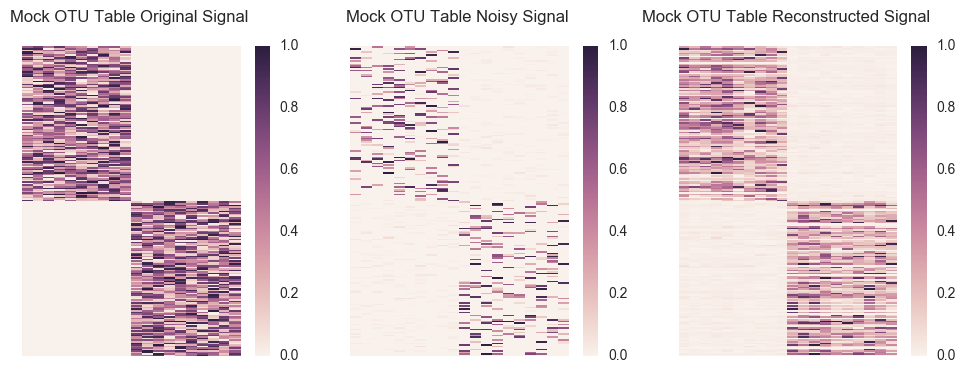

In [109]:
r=2 #numbers of blocks (rank of the matrix)
n=r*10 # number of columns (Samples)
b=n*10 # number of rows (OTUS)

# make a mock OTU table
X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 

# add noise
# now we add noise, we will add three types of noise: 
# 1:Homoscedastic noise (noise levels do not vary from measurement to measurement)
# 2:Heteroscedastic noise (noise levels do vary from measurement to measurement)
# 3: Low-density (coherce random values to zero)

X_noise=add_noise(X_true.copy(),.02,.01,.01,4)

#recover 
X_recovered=complete_matrix(X_noise.as_matrix().copy(),iteration=300)

#visualize 
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 4),sharey=False)
sns.heatmap(X_true,xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax1)
ax1.set_title('Mock OTU Table Original Signal \n',fontsize=fnts)
sns.heatmap(X_noise,xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax2)
ax2.set_title('Mock OTU Table Noisy Signal \n',fontsize=fnts)
sns.heatmap(X_recovered,xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax3)
ax3.set_title('Mock OTU Table Reconstructed Signal \n',fontsize=fnts)
plt.show()

As you can see above, the original signal can be mostly recovered from the noise using matrix completion. 

Random Forests is a form of supervised machine learning. Supervised machine learning is a method for developing predictive models from training data sets. This can reveal complex pattens in data associated with biologically important metadata such as disease states or environmental factors. 

For 16S rRNA gene amplicon studies the training data set used an OTU table (e.g. biom table). The metadata labels for each sample is recovered from the associated mapping file. This allows you to assign each sample into the appropriate environmental factor or patient data category.  

OTU tables contain low-density heteroscedastic noise and are difficult for supervised machine learning alogrithims to accurately predict. To overcome this problem we use matrix completion.
    
Cross-validation is done through taking a portion of the data (usually 80%) and predicting the remaining data (i.e. 20%). The score is the accuracy between the predicted data and the remaining data. The cross-validation score essentially tells you how accurate your supervised machine learning model is. 


#### To demonstrate how matrix completion can be uses for machine learning we will check the mean cross-validation score (mean of ten iterations) from 2 niches to 40 niches.  

In [268]:
#test machine learning 
lw=[]
nr=[]
rnagstart=2 #must be larger than two but less than rnagend
rnagend=11 # number of niches to check 
save_heat=[] # to visualize the otu table and certain points
save_heat_org=[]
save_heat_noisy=[]
for under_rank in range(rnagstart,rnagend):

    ### generate data ### 
    r=under_rank #numbers of blocks (rank of the matrix)
    n=r*10 # number of columns (Samples)
    b=n*10 # number of rows (OTUS)
    # make a mock mapping data
    mapping=pd.DataFrame(np.array([['Niche %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
    
    # make a mock OTU table
    X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 
    
    # add noise 
    X_noise=add_noise(X_true,0.02,0.09,.1,8)
    
    #save a few of them to view what it looks like
    if under_rank==rnagstart or under_rank==(rnagend-1)/2  or under_rank==(rnagend-1) :
        save_heat_org.append(X_true)
        save_heat_noisy.append(X_noise)
        
    #run machine learning 
    cross_valscores_lw,low_rank_data=machine_learning(X_noise,mapping,complete=True,iteration=100,mean_count=10)   
    lw.append(cross_valscores_lw.values[0][0])
    cross_valscores,low_rank_data=machine_learning(X_noise,mapping,complete=False,mean_count=10)   
    nr.append(cross_valscores.values[0][0])

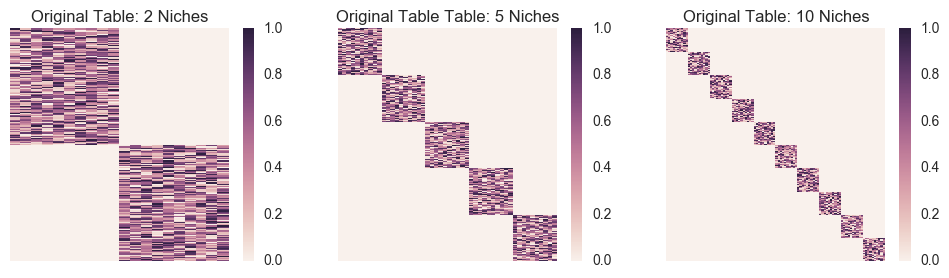

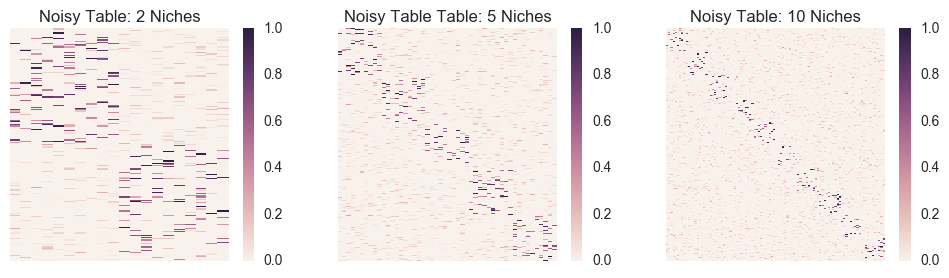

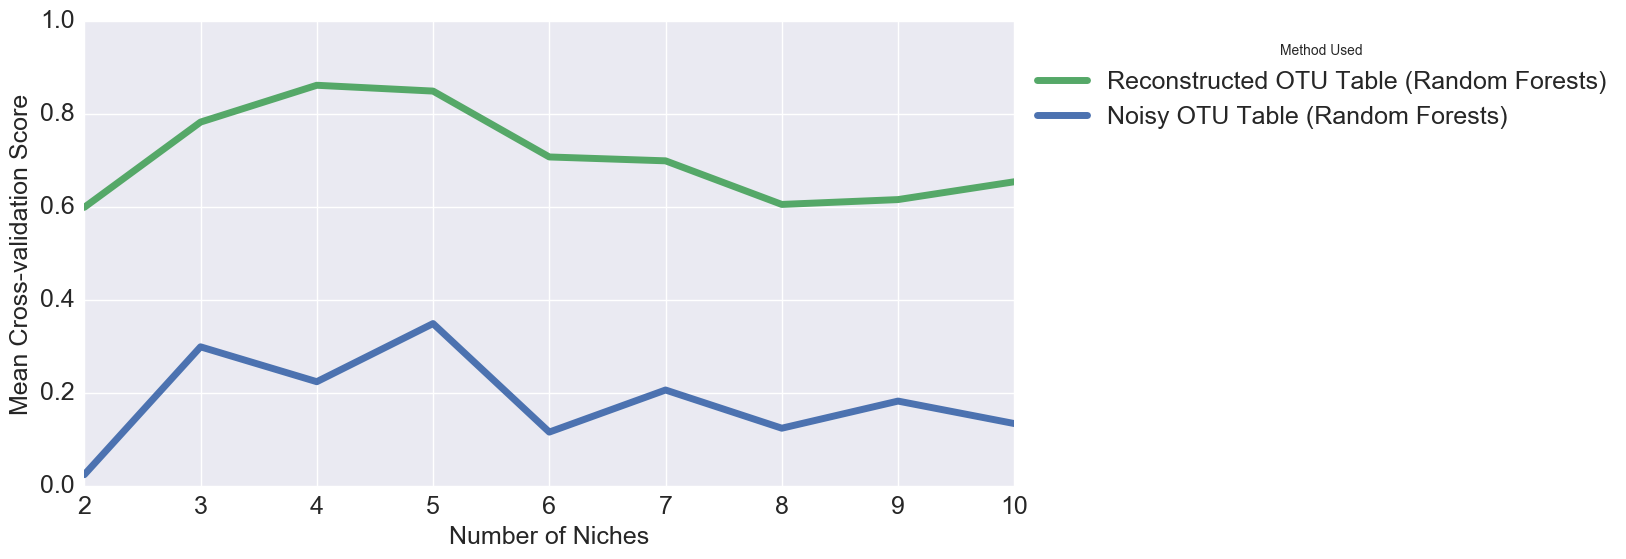

In [274]:
scores=pd.DataFrame({'Reconstructed OTU Table (Random Forests)': lw,'Noisy OTU Table (Random Forests)': nr,},index=list(range(rnagstart,rnagend)))     

#plot a few heatmaps
for save_heat,b4 in zip([save_heat_org,save_heat_noisy],['Original Table','Noisy Table']):
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 3),sharey=False)
    sns.heatmap(save_heat[0],xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax1)
    ax1.set_title('%s: %i Niches'%(b4,int(rnagstart)),fontsize=fnts)
    sns.heatmap(save_heat[1],xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax2)
    ax2.set_title('%s Table: %i Niches'%(b4,int((rnagend-1)/2)),fontsize=fnts)
    sns.heatmap(save_heat[2],xticklabels=False, yticklabels=False,vmin=0,vmax=1,ax=ax3)
    ax3.set_title('%s: %i Niches'%(b4,int(rnagend-1)),fontsize=fnts)
    plt.show()

#plot machine leanring scores 
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12, 6),sharey=True)
scores.plot(ylim=(0,1),lw=5,ax=ax1,fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':18}, bbox_to_anchor=(1.0, 1.0),title='Method Used')
ax1.set_xlabel('Number of Niches',fontsize=18)
ax1.set_ylabel('Mean Cross-validation Score',fontsize=18)
plt.show()

Now we can see that the cross-validation scores are significantly increased in the recovered OTU table by matrix completion. This means the machine learning is able to locate the patterns much more clearly in reconstructed data. 

### clr-PCA on matrix completed data 


clr-PCA on matrix completed data can relate ecology directly to ordination and should be similar to the PCoA in cluster representation. Furthermore we will demonstrate clr-PCA robustness by comparing it to PCA and PCoA.

To demonstrate this we test a mock OTU table with 2 niches and then an OTU table with equal number of niches to samples. 

To make it easy to visualize we will use a simple plotting function

In [177]:
def _scatter(ax1,reduced,catvis,legendadd=False):
        for ((key, grp)) in reduced.groupby(catvis):
            ax1.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
        ax1.set_xlabel('$PC-1$')
        ax1.set_ylabel('$PC-2$')
        ax1.set_xticks([])
        ax1.set_yticks([])
        if legendadd==True:
            ax1.legend(loc=2,prop={'size':12},bbox_to_anchor=(1.0, 1.0))

def _scatter_cont(ax1,reduced,catvis,legendadd=False):            
        reduced.plot.scatter(x='PC1', y='PC2', c=str(catvis), s=50,ax=ax1);
        ax1.set_xlabel('$PC-1$')
        ax1.set_ylabel('$PC-2$')
        ax1.set_xticks([])
        ax1.set_yticks([])
        
def compare_plots(X_true,X_noise,mapping,catvis,minvalues,iterations,hmax=1):
    
    if all(isinstance(item, str) for item in list(mapping[catvis])):
        __scatter=_scatter
    else:
        __scatter=_scatter_cont
    
    heatitles=['Mock OTU Table Original Signal','Mock OTU Table Noisy Signal']
    
    for count, data in enumerate([X_true,X_noise]):

        fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, nrows=1, figsize=(16, 3)) 
        sns.heatmap(data,xticklabels=False, yticklabels=False,vmin=0,vmax=hmax,ax=ax1)
        ax1.set_title(heatitles[count])
        __scatter(ax2,reduce_plot(data,mapping.T,catvis,method='PCA',reduce_only=True),catvis)
        ax2.set_title('PCA')
        __scatter(ax3,reduce_plot(data,mapping.T,catvis,method='PCoA',reduce_only=True),catvis)
        ax3.set_title('PCoA')
        __scatter(ax4,reduce_plot(data,mapping.T,catvis,method='clrPCA',reduce_only=True,iters=iterations[count],min_val=minvalues[count]),catvis,legendadd=True)
        ax4.set_title('clr-PCA on Reconstructed data')


First we will use the mock data where there is two clear niches, this could be something like sick and healthy. 

In [179]:
### generate data ### 
r=2 #numbers of blocks (rank of the matrix)
n=r*100 # number of columns (Samples)
b=n*10 # number of rows (OTUS)
minvalues=[1e-50,1] #minimum values for matrix completion (must be >0 for clr transoform)
iterations=[100,300] #number of iterations for matrix completion 
# make a mock mapping data
mapping=pd.DataFrame(np.array([['Niche %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
# make a mock OTU table
X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 

 Now we will use our plotting function to visualize the PCA, PCoA and clr-PCA (scatter plots left to right) on reconstructed data for the OTU table before (top) and after we add noise (bottom). 

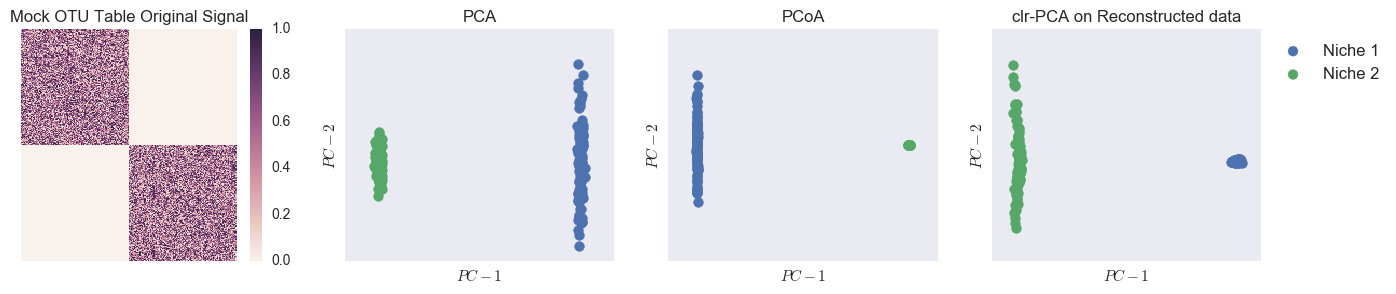

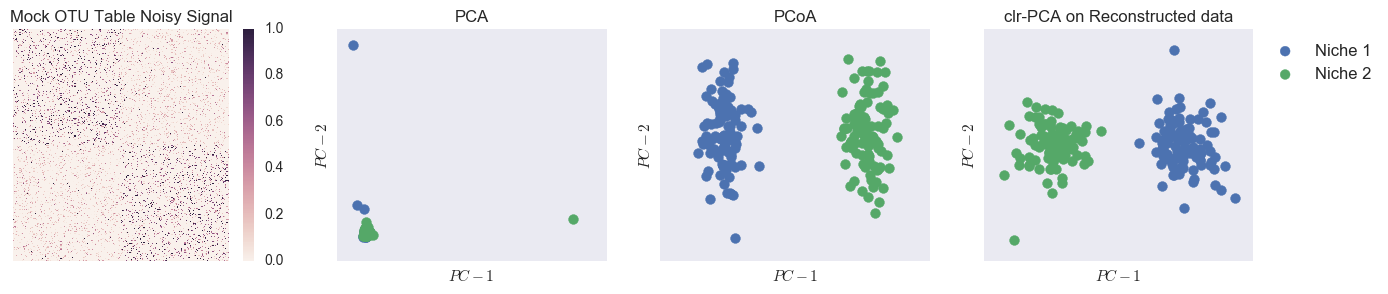

In [180]:
compare_plots(X_true,add_noise(X_true,0.2,0.1,8,8),mapping,'example',minvalues,iterations)

 From this it is clear that PCA is easily skewed by low-density heteroscedastic noise while PCoA and clr-PCA can recreate the trend between the two niches. 

 Often times each sample has very few overlapping OTUs with the other samples, this forms a gradient in the OTU table. It can be said this case occurs when the number of niches approaches the number of samples, similar to when we had many niches in the machine learning example. Let's see how clr-PCA compares in this type of distribution.  

In [230]:
# intials 
n=100 # number of samples
b=55  # size of the gradient band 
rb=5  # number of OTUs in first sample
bn=10  # number of OTUs in last sample / 2
minvalues=[1,1e-4]
iterations=[100,200] #number of iterations for matrix completion 
# make a mock OTU table
X_true=util.band_diagonal(n,b).T
X_true*=np.random.random(X_true.shape)
X_true=np.delete(X_true, np.s_[0:rb], axis=1) 
X_true=np.delete(X_true, np.s_[n-bn:], axis=1) 
# mock OTU to dataframe
X_true=pd.DataFrame(X_true,columns=['sample_'+str(x) for x in range(0,X_true.shape[1])],index=['OTU_'+str(x) for x in range(0,X_true.shape[0])]) 
# make a mock mapping data
mapping=pd.DataFrame(np.array([x for x in range(0,X_true.shape[1])]),columns=['Gradient (i.e. pH)'],index=['sample_'+str(x) for x in range(0,X_true.shape[1])])

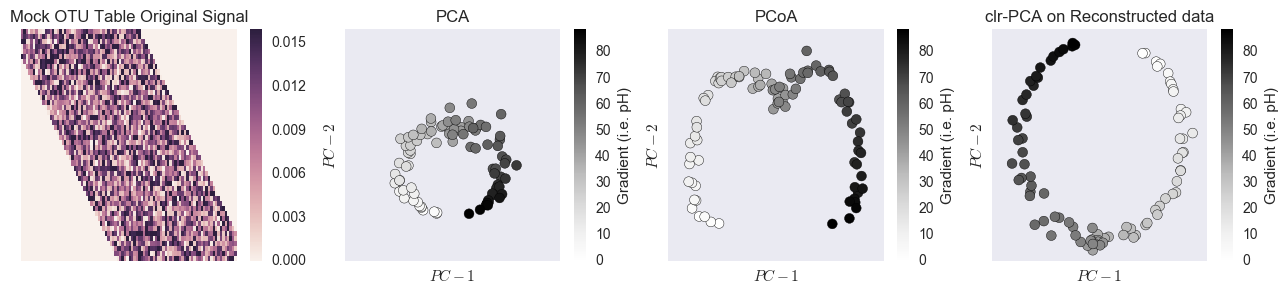

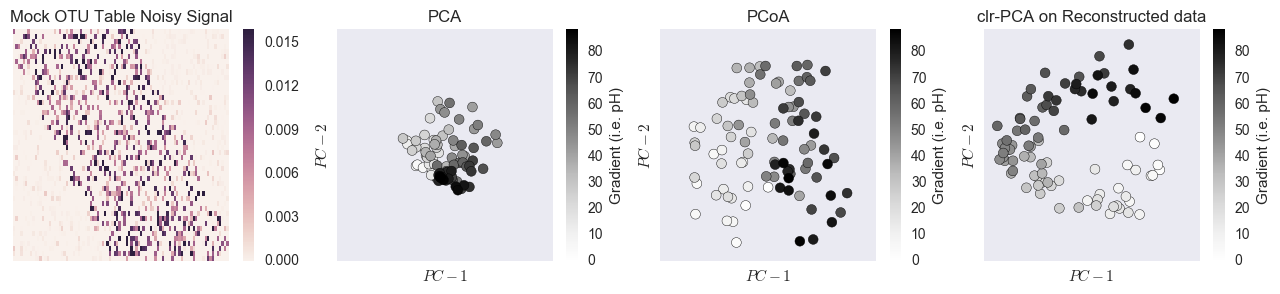

In [232]:
compare_plots(X_true,add_noise(X_true,0.0002,0.001,.0001,3),mapping,'Gradient (i.e. pH)',minvalues,iterations,hmax=.016)

Again it is clear that PCA is easily skewed by low-density heteroscedastic noise while PCoA and clr-PCA can recreate the gradient trend. 

In conclusion, matrix completion and clr-PCA are an alternative, yet powerful approach at analyzing the community structure of a population. 

 [Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/88_soils.ipynb)